In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import griddata
from Klein_Gordon_model_tf import Sampler, Klein_Gordon
import scipy.io

D:\anaconda\envs\tf\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
D:\anaconda\envs\tf\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
D:\anaconda\envs\tf\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
D:\anaconda\envs\tf\lib\site-packages\tensorflow\python\framework\dtypes.py:529: FutureWarning: Passing (type, 1) or '1ty

In [2]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
np.random.seed(1236)
tf.set_random_seed(1236)

In [3]:
if __name__ == '__main__':
    def u(x):
        """
        :param x: x = (t, x)
        """
        return x[:, 1:2] * np.cos(5 * np.pi * x[:, 0:1]) + (x[:, 0:1] * x[:, 1:2])**3

    def u_tt(x):
        return - 25 * np.pi**2 * x[:, 1:2] * np.cos(5 * np.pi * x[:, 0:1]) + 6 * x[:,0:1] * x[:,1:2]**3

    def u_xx(x):
        return np.zeros((x.shape[0], 1)) +  6 * x[:,1:2] * x[:,0:1]**3

    def f(x, alpha, beta, gamma, k):
        return u_tt(x) + alpha * u_xx(x) + beta * u(x) + gamma * u(x)**k

    def operator(u, t, x, alpha, beta, gamma, k,  sigma_t=1.0, sigma_x=1.0):
        u_t = tf.gradients(u, t)[0] / sigma_t
        u_x = tf.gradients(u, x)[0] / sigma_x
        u_tt = tf.gradients(u_t, t)[0] / sigma_t
        u_xx = tf.gradients(u_x, x)[0] / sigma_x
        residual = u_tt + alpha * u_xx + beta * u + gamma * u**k
        return residual

    # Parameters of equations
    alpha = -1.0
    beta = 0.0
    gamma = 1.0
    k = 3

    # Domain boundaries
    ics_coords = np.array([[0.0, 0.0],
                           [0.0, 1.0]])
    bc1_coords = np.array([[0.0, 0.0],
                           [1.0, 0.0]])
    bc2_coords = np.array([[0.0, 1.0],
                           [1.0, 1.0]])
    dom_coords = np.array([[0.0, 0.0],
                           [1.0, 1.0]])

    # Create initial conditions samplers
    ics_sampler = Sampler(2, ics_coords, lambda x: u(x), name='Initial Condition 1')

    # Create boundary conditions samplers
    bc1 = Sampler(2, bc1_coords, lambda x: u(x), name='Dirichlet BC1')
    bc2 = Sampler(2, bc2_coords, lambda x: u(x), name='Dirichlet BC2')
    bcs_sampler = [bc1, bc2]

    # Create residual sampler
    res_sampler = Sampler(2, dom_coords, lambda x: f(x, alpha, beta, gamma, k), name='Forcing')

    # Define model
    layers = [2, 150, 150, 150, 150, 150, 1]
    mode = 'M4'          # Method: 'M1', 'M2', 'M3', 'M4'
    stiff_ratio = False  # Log the eigenvalues of Hessian of losses
    model = Klein_Gordon(layers, operator, ics_sampler, bcs_sampler, res_sampler, u,alpha, beta, gamma, k, mode, stiff_ratio)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [4]:
    # Train model
    model.train(nIter=40001, batch_size=256)

It: 0, Loss: 1.054e+04, Loss_u: 1.239e+00, Loss_r: 1.054e+04, Time: 9.16
constant_ics_val: 133.258, constant_bcs_val: 268.790
Relative L2 error_u: 1.11e+00
Gradients information stored ...
It: 1000, Loss: 3.589e+00, Loss_u: 2.763e+00, Loss_r: 8.263e-01, Time: 376.84
constant_ics_val: 120.046, constant_bcs_val: 260.963
Relative L2 error_u: 2.14e-02
It: 2000, Loss: 2.093e+00, Loss_u: 1.565e+00, Loss_r: 5.276e-01, Time: 240.76
constant_ics_val: 108.270, constant_bcs_val: 243.069
Relative L2 error_u: 1.77e-02
It: 3000, Loss: 3.023e+00, Loss_u: 2.287e+00, Loss_r: 7.363e-01, Time: 239.60
constant_ics_val: 97.695, constant_bcs_val: 239.766
Relative L2 error_u: 1.30e-02
It: 4000, Loss: 1.790e-01, Loss_u: 5.065e-02, Loss_r: 1.283e-01, Time: 240.01
constant_ics_val: 89.240, constant_bcs_val: 259.548
Relative L2 error_u: 1.11e-02
It: 5000, Loss: 3.836e-02, Loss_u: 4.948e-03, Loss_r: 3.341e-02, Time: 240.00
constant_ics_val: 82.214, constant_bcs_val: 240.248
Relative L2 error_u: 8.60e-03
It: 6000,

In [5]:
    # Test data
    nn = 100
    t = np.linspace(dom_coords[0, 0], dom_coords[1, 0], nn)[:, None]
    x = np.linspace(dom_coords[0, 1], dom_coords[1, 1], nn)[:, None]
    t, x = np.meshgrid(t, x)
    X_star = np.hstack((t.flatten()[:, None], x.flatten()[:, None]))

    # Exact solution
    u_star = u(X_star)
    f_star = f(X_star, alpha, beta, gamma, k)

    # Predictions
    u_pred = model.predict_u(X_star)

    error_u = np.linalg.norm(u_star - u_pred, 2) / np.linalg.norm(u_star, 2)
    print('Relative L2 error_u: {:.2e}'.format(error_u))

Relative L2 error_u: 1.18e-03


In [6]:
    # Test data
    U_star = griddata(X_star, u_star.flatten(), (t, x), method='cubic')
    F_star = griddata(X_star, f_star.flatten(), (t, x), method='cubic')

    U_pred = griddata(X_star, u_pred.flatten(), (t, x), method='cubic')

D:\anaconda\envs\tf\lib\site-packages\ipykernel_launcher.py:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  This is separate from the ipykernel package so we can avoid doing imports until
D:\anaconda\envs\tf\lib\site-packages\ipykernel_launcher.py:10: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  # Remove the CWD from sys.path while we load stuff.
D:\anaconda\envs\tf\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: shading='flat' wh

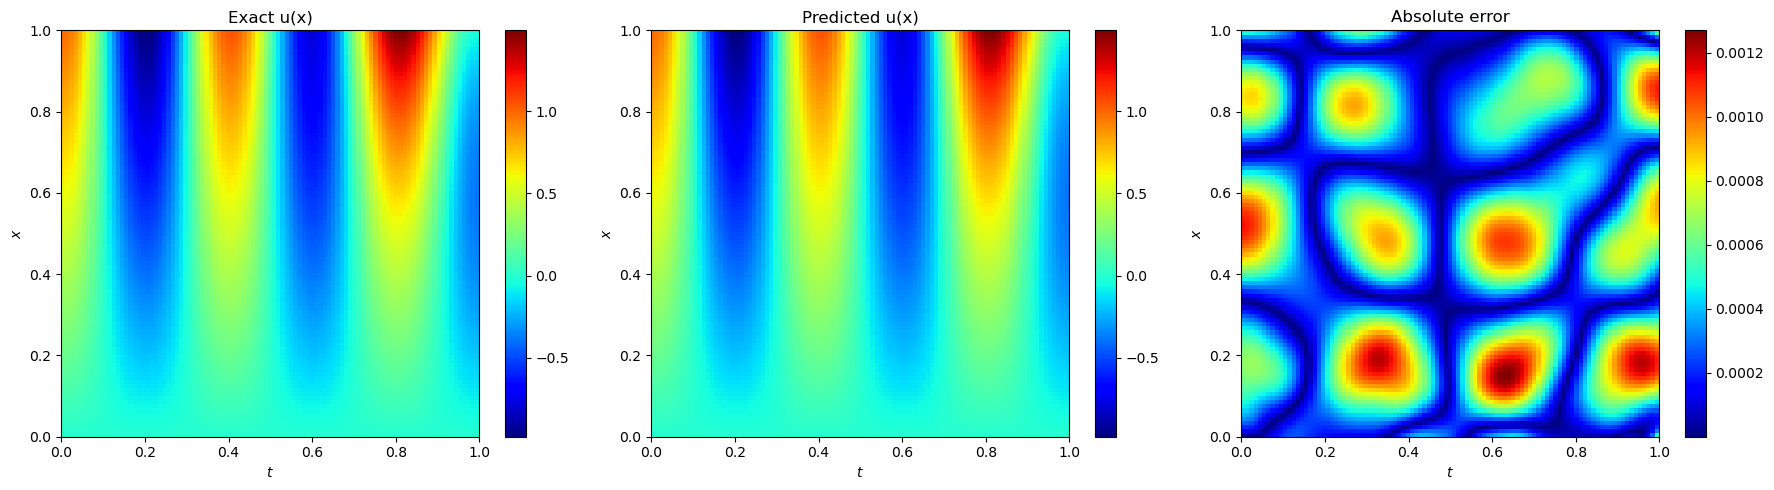

In [7]:
    fig_1 = plt.figure(1, figsize=(18, 5))
    plt.subplot(1, 3, 1)
    plt.pcolor(t, x, U_star, cmap='jet')
    plt.colorbar()
    plt.xlabel('$t$')
    plt.ylabel('$x$')
    plt.title('Exact u(x)')

    plt.subplot(1, 3, 2)
    plt.pcolor(t, x, U_pred, cmap='jet')
    plt.colorbar()
    plt.xlabel('$t$')
    plt.ylabel('$x$')
    plt.title('Predicted u(x)')

    plt.subplot(1, 3, 3)
    plt.pcolor(t, x, np.abs(U_star - U_pred), cmap='jet')
    plt.colorbar()
    plt.xlabel('$t$')
    plt.ylabel('$x$')
    plt.title('Absolute error')
    plt.tight_layout()
    plt.show()

In [8]:
scipy.io.savemat("1.mat", {'u': u_pred}) 

In [9]:
    l2_error = model.l2_error_log

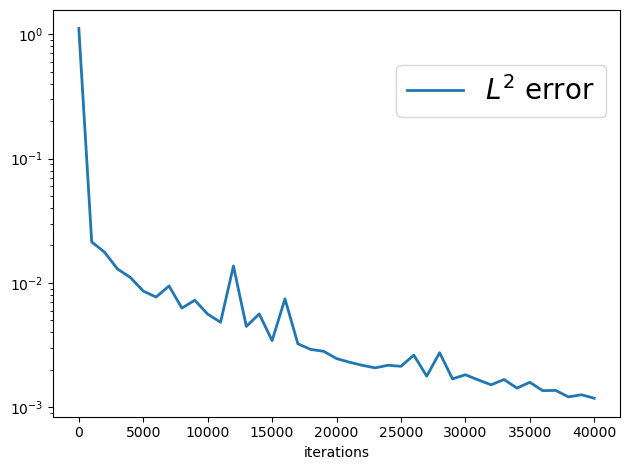

In [10]:
        iters = 1000 * np.arange(len(l2_error))
        plt.plot(iters, l2_error, label=r'$L^2$ error', linewidth=2)

        plt.yscale('log')
        plt.xlabel('iterations')
        plt.legend(loc='upper right', bbox_to_anchor=(1.0, 0.9), fontsize=20)
        plt.tight_layout()
        plt.show()

In [11]:
scipy.io.savemat("2.mat", {'l2': l2_error}) 